In [84]:
import h2o
import operator
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
from matplotlib import pyplot as plt
import warnings
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators import H2OGradientBoostingEstimator
warnings.filterwarnings("ignore")

# Data Preparation

In [2]:
pct_memory=4
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

29


In [3]:
h2o.init(strict_version_check=False,max_mem_size=min_mem_size)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "10.0.2" 2018-07-17; Java(TM) SE Runtime Environment 18.3 (build 10.0.2+13); Java HotSpot(TM) 64-Bit Server VM 18.3 (build 10.0.2+13, mixed mode)
  Starting server from /anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/5l/qqvypzcs2sjbbnhb777lxczh0000gn/T/tmp89v3i0pf
  JVM stdout: /var/folders/5l/qqvypzcs2sjbbnhb777lxczh0000gn/T/tmp89v3i0pf/h2o_mandy_started_from_python.out
  JVM stderr: /var/folders/5l/qqvypzcs2sjbbnhb777lxczh0000gn/T/tmp89v3i0pf/h2o_mandy_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,16 days
H2O cluster name:,H2O_from_python_mandy_i9uung
H2O cluster total nodes:,1
H2O cluster free memory:,29 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"accepting new members, healthy"


In [4]:
data_path = "AmazonReviews.Small.csv"

# Load data into H2O
reviews = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [5]:
reviews['PositiveReview']=(reviews['Score']>=4.2).ifelse('1','0')

In [6]:
reviews['PositiveReview'].table()

PositiveReview,Count
0,20106
1,35448


In [7]:
reviews['PositiveReview'].table()

PositiveReview,Count
0,20106
1,35448


In [8]:
# Find the 80th quantile of time in the dataset
time_split = reviews["Time"].quantile(prob = [0.8])[1]
reviews["Train"] = (reviews["Time"] < time_split).ifelse("Yes", "No")

In [9]:
train = reviews[reviews["Train"] == "Yes"]
test = reviews[reviews["Train"] == "No"]

In [12]:
data_path = "stopwords.csv"

STOP_WORDS = pd.read_csv(data_path, header=0)
STOP_WORDS = list(STOP_WORDS['STOP_WORD'])

In [13]:
def tokenize(sentences, stop_word = STOP_WORDS):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)),:]
    return tokenized_words

In [14]:
# Break reviews into sequence of words
words = tokenize(reviews["Text"])

In [15]:
words.head()

C1
made
china
buy
pet
food
china
dogswell
using
propylene
glycol


In [16]:
# Train Word2Vec Model
from h2o.estimators.word2vec import H2OWord2vecEstimator


w2v_model = H2OWord2vecEstimator(vec_size = 100, model_id = "w2v.hex")
w2v_model.train(training_frame=words)

models_path='data'
h2o.save_model(w2v_model, path = models_path, force = True)

word2vec Model Build progress: |██████████████████████████████████████████| 100%


'/Users/mandy/Documents/Study/Lessons/6105/AI-Addin/data/w2v.hex'

In [17]:
# Sanity check - find synonyms for the word 'coffee'
w2v_model.find_synonyms("coffee", count = 5)

OrderedDict([('coffees', 0.7859161496162415),
             ('coffe', 0.7757903933525085),
             ('espresso', 0.7516980171203613),
             ('expresso', 0.7513675093650818),
             ('brew', 0.7510714530944824)])

In [18]:
# Sanity check - find synonyms for the word 'stale'
w2v_model.find_synonyms("stale", count = 5)

OrderedDict([('rancid', 0.6972429752349854),
             ('unedible', 0.6676676273345947),
             ('staleness', 0.64045250415802),
             ('overbaked', 0.6243177652359009),
             ('tasteless', 0.6234351396560669)])

In [19]:
# Calculate a vector for each review
review_vecs = w2v_model.transform(words, aggregate_method = "AVERAGE")
review_vecs

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
0.12917,0.0299455,-0.0490899,0.00893291,0.0190802,-0.00610951,0.0120351,-0.334961,0.161847,-0.0663551,-0.109759,-0.00641763,0.0887674,0.191471,0.0549513,-0.144631,-0.0474062,0.0995626,0.0134732,0.0396906,-0.0368953,-0.19288,0.0790057,-0.00657185,0.0905049,0.117006,0.0382062,0.0893816,0.102397,0.0572057,0.233991,0.158946,0.196584,-0.160502,0.0690184,-0.0863937,0.0405308,0.13917,-0.0265374,-0.0218064,0.0099681,-0.156008,0.0308868,-0.137468,0.0246485,-0.0364001,-0.107721,-0.1641,0.0630564,-0.224799,0.102297,0.0340673,-0.129526,0.131943,-0.0279314,0.0284462,-0.111921,0.158484,0.0485629,-0.0517763,-0.0669737,0.204902,0.070655,-0.106908,-0.0713758,-0.0182628,0.0699829,-0.00538563,0.0394679,0.0502924,0.0668489,-0.0501116,0.313984,0.0276574,-0.118442,-0.0181206,0.0535085,0.070737,-0.0708572,-0.0453052,0.0181514,0.160654,0.0700613,-0.00154031,-0.102484,-0.0431368,-0.0862916,0.109466,-0.00336389,0.113831,0.0402905,0.0238592,-0.185985,0.0926318,-0.0311738,-0.137986,-0.0343636,-0.196328,0.119503,0.0379679
0.0185988,0.205654,-0.213451,0.0881322,-0.026778,-0.114138,-0.0710233,0.0257435,0.289505,-0.0558199,-0.119363,0.188334,0.0314669,0.122508,0.17663,-0.106895,0.163716,-0.0379743,-0.00431046,0.0274768,0.0210197,-0.0468156,-0.159791,-0.114791,0.0235751,-0.101575,0.061798,0.0335133,0.0386808,-0.0310535,0.121843,0.23477,0.127345,-0.1751,0.0518926,-0.0726755,-0.113054,-0.0923534,-0.0329874,0.0299116,0.107482,-0.162709,0.186311,-0.116504,-0.0116403,-0.0361627,-0.234973,0.0251932,-0.0441221,-0.067011,0.104726,0.0609187,0.160423,0.236405,0.180013,-0.0223651,-0.072517,0.00252662,0.0814018,-0.0179177,-0.075991,0.14799,-0.0391576,-0.0786622,-0.0560698,0.00473555,0.0590133,-0.139362,0.13548,-0.118203,-0.0482412,-0.112342,0.123092,0.0386636,-0.0305218,-0.0394496,-0.0379041,-0.0379979,-0.0743732,-0.0785754,-0.0348918,0.0525545,-0.0349363,0.0826198,-0.070651,-0.0393718,-0.0819873,0.0595535,0.01269,0.179319,0.0764434,0.0274205,-0.303293,-0.0718099,0.15155,-0.057007,-0.0916376,0.0596572,-0.0152745,0.150984
0.060313,-0.115611,0.00167719,0.0844067,-0.0542967,-0.203262,-0.0646622,-0.0935464,0.109586,-0.0539923,-0.0291927,0.0254051,-0.0876865,0.0741222,0.105812,0.00299753,-0.0270305,0.0782517,0.0945997,0.0501357,0.0352763,-0.0627455,0.0791841,-0.00687353,0.0473105,0.000328656,-0.0626824,0.0251238,0.0767176,0.121644,0.18164,0.279703,0.174516,-0.121252,-0.0251613,-0.0153807,0.0769472,0.064934,-0.0263007,0.105055,-0.0434598,-0.278027,0.106152,-0.0775082,-0.0541208,-0.077881,-0.170916,-0.0572134,0.0199556,-0.0874221,0.138198,-0.0663306,0.0675663,0.157848,0.0884277,-0.0433774,-0.0636752,0.0199444,0.0244142,-0.0259011,-0.0938728,0.201822,0.153278,-0.278858,-0.0213931,-0.000171979,-0.0663742,-0.100037,0.110744,0.00411301,0.0825984,-0.158723,0.183622,-0.00994533,-0.127098,0.0841783,0.0609244,0.0474106,-0.0110054,-0.0187034,0.046951,0.0831642,0.0828919,-0.047945,-0.158531,-0.0326801,-0.0732946,0.141952,-0.106875,0.114859,0.0916932,0.00653966,-0.21404,0.0681284,0.00501457,-0.119693,-0.0617665,-0.138928,-0.0194709,0.109409
0.0139276,0.0489609,-0.0275456,-0.0369436,0.0188345,-0.180233,0.00881093,-0.0880943,0.24004,-0.0133689,-0.193296,0.00709764,-0.0072059,0.115879,0.0781857,0.0189767,0.138875,0.0227574,0.044154,-0.0244546,0.0296189,-0.17635,0.0744128,0.0604016,0.00867721,-0.0322506,-0.00550359,0.0398344,0.148177,0.0995515,0.219444,0.175519,0.271141,0.0363153,0.0248795,0.105378,0.00815416,0.0611049,-0.00554313,-0.0224043,-0.0450975,-0.256222,0.0686169,-0.0711233,-0.0523793,-0.126771,-0.179101,-0.132789,0.0638172,-0.154065,0.219284,-0.122001,0.0870339,0.146888,0.109527,-0.0307422,0.036249

In [20]:
# Add aggregated word embeddings 
ext_reviews = reviews.cbind(review_vecs)

In [22]:
ext_reviews.head(3)

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview,Train,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one.",0,No,0.12917,0.0299455,-0.0490899,0.00893291,0.0190802,-0.00610951,0.0120351,-0.334961,0.161847,-0.0663551,-0.109759,-0.00641763,0.0887674,0.191471,0.0549513,-0.144631,-0.0474062,0.0995626,0.0134732,0.0396906,-0.0368953,-0.19288,0.0790057,-0.00657185,0.0905049,0.117006,0.0382062,0.0893816,0.102397,0.0572057,0.233991,0.158946,0.196584,-0.160502,0.0690184,-0.0863937,0.0405308,0.13917,-0.0265374,-0.0218064,0.0099681,-0.156008,0.0308868,-0.137468,0.0246485,-0.0364001,-0.107721,-0.1641,0.0630564,-0.224799,0.102297,0.0340673,-0.129526,0.131943,-0.0279314,0.0284462,-0.111921,0.158484,0.0485629,-0.0517763,-0.0669737,0.204902,0.070655,-0.106908,-0.0713758,-0.0182628,0.0699829,-0.00538563,0.0394679,0.0502924,0.0668489,-0.0501116,0.313984,0.0276574,-0.118442,-0.0181206,0.0535085,0.070737,-0.0708572,-0.0453052,0.0181514,0.160654,0.0700613,-0.00154031,-0.102484,-0.0431368,-0.0862916,0.109466,-0.00336389,0.113831,0.0402905,0.0238592,-0.185985,0.0926318,-0.0311738,-0.137986,-0.0343636,-0.196328,0.119503,0.0379679
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring.",0,Yes,0.0185988,0.205654,-0.213451,0.0881322,-0.026778,-0.114138,-0.0710233,0.0257435,0.289505,-0.0558199,-0.119363,0.188334,0.0314669,0.122508,0.17663,-0.106895,0.163716,-0.0379743,-0.00431046,0.0274768,0.0210197,-0.0468156,-0.159791,-0.114791,0.0235751,-0.101575,0.061798,0.0335133,0.0386808,-0.0310535,0.121843,0.23477,0.127345,-0.1751,0.0518926,-0.0726755,-0.113054,-0.0923534,-0.0329874,0.0299116,0.107482,-0.162709,0.186311,-0.116504,-0.0116403,-0.0361627,-0.234973,0.0251932,-0.0441221,-0.067011,0.104726,0.0609187,0.160423,0.236405,0.180013,-0.0223651,-0.072517,0.00252662,0.0814018,-0.0179177,-0.075991,0.14799,-0.0391576,-0.0786622,-0.0560698,0.00473555,0.0590133,-0.139362,0.13548,-0.118203,-0.0482412,-0.112342,0.123092,0.0386636,-0.0305218,-0.0394496,-0.0379041,-0.0379979,-0.0743732,-0.0785754,-0.0348918,0.0525545,-0.0349363,0.0826198,-0.070651,-0.0393718,-0.0819873,0.0595535,0.01269,0.179319,0.0764434,0.0274205,-0.303293,-0.0718099,0.15155,-0.057007,-0.0916376,0.0596572,-0.0152745,0.150984
B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1.3106e+09,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)",1,Yes,0.060313,-0.115611,0.00167719,0.0844067,-0.0542967,-0.203262,-0.0646622,-0.0935464,0.109586,-0.0539923,-0.0291927,0.0254051,-0.0876865,0.0741222,0.105812,0.00299753,-0.0270305,0.0782517,0.0945997,0.0501357,0.0352763,-0.0627455,0.0791841,-0.00687353,0.0473105,0.000328656,-0.0626824,0.0251238,0.0767176,0.121644,0.18164,0.279703,0.174516,-0.121252,-0.0251613,-0.0153807,0.0769472,0.064934,-0.0263007,0.105055,-0.043

In [23]:
# Break summaries into sequence of word.
summary_words = tokenize(reviews['Summary'].ascharacter())

In [24]:
summary_vecs = w2v_model.transform(summary_words, aggregate_method='AVERAGE')
summary_vecs.names = ['summary_'+ s for s in summary_vecs.names]

ext_reviews_new = ext_reviews.cbind(summary_vecs)

In [25]:
ext_reviews_new.head(3)

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview,Train,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100,summary_C1,summary_C2,summary_C3,summary_C4,summary_C5,summary_C6,summary_C7,summary_C8,summary_C9,summary_C10,summary_C11,summary_C12,summary_C13,summary_C14,summary_C15,summary_C16,summary_C17,summary_C18,summary_C19,summary_C20,summary_C21,summary_C22,summary_C23,summary_C24,summary_C25,summary_C26,summary_C27,summary_C28,summary_C29,summary_C30,summary_C31,summary_C32,summary_C33,summary_C34,summary_C35,summary_C36,summary_C37,summary_C38,summary_C39,summary_C40,summary_C41,summary_C42,summary_C43,summary_C44,summary_C45,summary_C46,summary_C47,summary_C48,summary_C49,summary_C50,summary_C51,summary_C52,summary_C53,summary_C54,summary_C55,summary_C56,summary_C57,summary_C58,summary_C59,summary_C60,summary_C61,summary_C62,summary_C63,summary_C64,summary_C65,summary_C66,summary_C67,summary_C68,summary_C69,summary_C70,summary_C71,summary_C72,summary_C73,summary_C74,summary_C75,summary_C76,summary_C77,summary_C78,summary_C79,summary_C80,summary_C81,summary_C82,summary_C83,summary_C84,summary_C85,summary_C86,summary_C87,summary_C88
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one.",0,No,0.12917,0.0299455,-0.0490899,0.00893291,0.0190802,-0.00610951,0.0120351,-0.334961,0.161847,-0.0663551,-0.109759,-0.00641763,0.0887674,0.191471,0.0549513,-0.144631,-0.0474062,0.0995626,0.0134732,0.0396906,-0.0368953,-0.19288,0.0790057,-0.00657185,0.0905049,0.117006,0.0382062,0.0893816,0.102397,0.0572057,0.233991,0.158946,0.196584,-0.160502,0.0690184,-0.0863937,0.0405308,0.13917,-0.0265374,-0.0218064,0.0099681,-0.156008,0.0308868,-0.137468,0.0246485,-0.0364001,-0.107721,-0.1641,0.0630564,-0.224799,0.102297,0.0340673,-0.129526,0.131943,-0.0279314,0.0284462,-0.111921,0.158484,0.0485629,-0.0517763,-0.0669737,0.204902,0.070655,-0.106908,-0.0713758,-0.0182628,0.0699829,-0.00538563,0.0394679,0.0502924,0.0668489,-0.0501116,0.313984,0.0276574,-0.118442,-0.0181206,0.0535085,0.070737,-0.0708572,-0.0453052,0.0181514,0.160654,0.0700613,-0.00154031,-0.102484,-0.0431368,-0.0862916,0.109466,-0.00336389,0.113831,0.0402905,0.0238592,-0.185985,0.0926318,-0.0311738,-0.137986,-0.0343636,-0.196328,0.119503,0.0379679,-0.0850244,0.0553057,-0.00158559,0.063723,-0.133546,-0.175626,0.161326,-0.0967465,0.468559,-0.218463,-0.378517,0.0666172,0.249015,0.0887967,0.10051,-0.279991,0.298551,-0.0128812,0.167878,-0.030772,0.170752,-0.186787,0.044023,0.120993,0.0298747,-0.0457761,-0.00310036,-0.0726606,0.162031,-0.035588,0.0837039,0.156766,0.0789666,-0.00660802,0.127046,-0.190599,0.0970704,0.137221,-0.105718,0.107363,0.0418045,-0.271857,0.110638,-0.072426,0.0436282,-0.0258275,-0.281228,0.235959,0.075495,-0.204442,0.0779554,0.0333634,-0.156122,0.0944928,-0.174269,0.0734238,-0.0465348,0.189584,-0.00319107,-0.105361,0.201907,0.110281,0.151295,-0.191801,-0.190152,0.0382816,0.0860977,0.248459,-0.00318289,-0.100631,-0.0587916,-0.183613,0.399387,0.145911,-0.224106,-0.110312,0.228763,0.0340951,0.00958472,0.479287,0.363762,0.208209,-0.00836943,-0.11831,-0.0410315,0.38917,-0.124132,0.0107559
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it 

In [43]:
ext_train_new = ext_reviews_new[ext_reviews_new["Train"] == "Yes"]
ext_test_new = ext_reviews_new[ext_reviews_new["Train"] == "No"]

# Training Models

## 1 Linear Regression

### 1.1 Train & Fit Model

In [50]:
predictors = ['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time'] + summary_vecs.names + review_vecs.names 
response = 'PositiveReview'

In [51]:
# Initialize
local_glm_plus = H2OGeneralizedLinearEstimator(family='binomial', model_id='glm_surrogate', lambda_search=True)
# train 
local_glm_plus.train(x=predictors, y=response, training_frame=ext_train_new)

glm Model Build progress: |███████████████████████████████████████████████| 100%


### 1.2 Interpretability

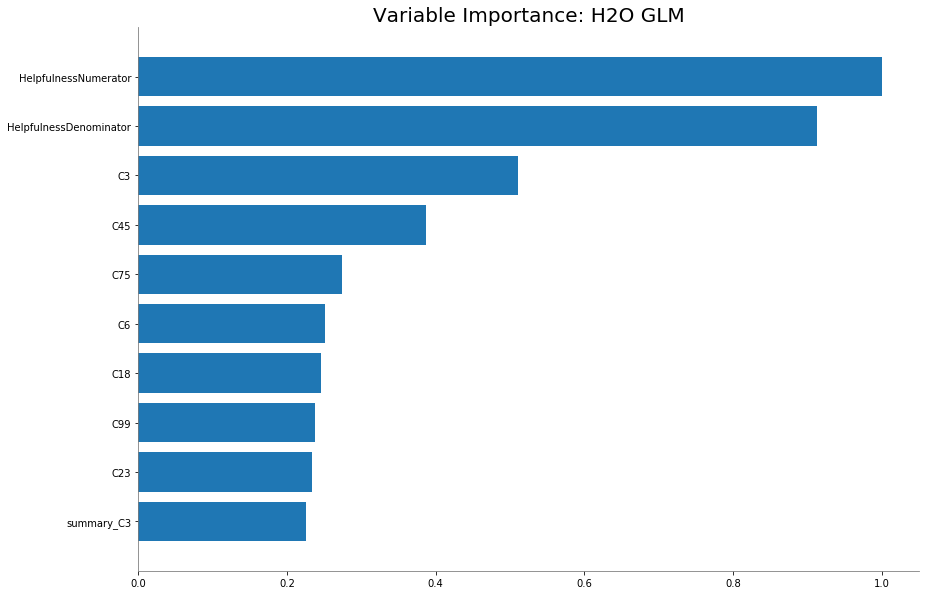

In [55]:
local_glm_plus.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


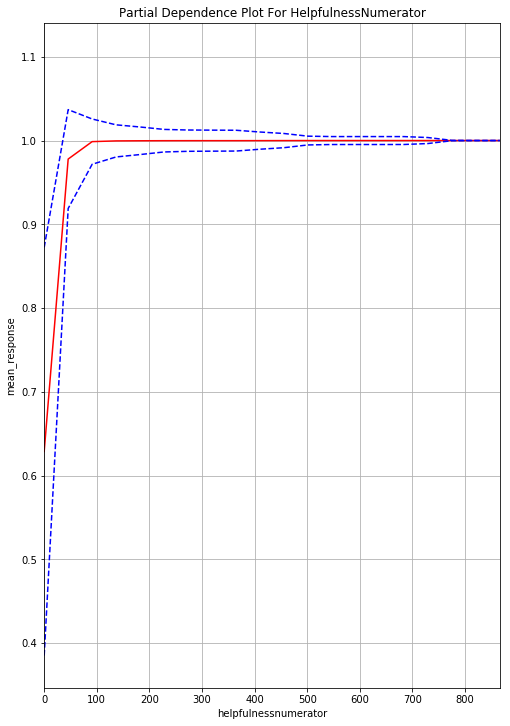

In [56]:
pdp_local_linear_plus = local_glm_plus.partial_plot(data = ext_train, cols = ["HelpfulnessNumerator"])

### 1.3 Matrix

In [57]:
print('\nLocal GLM Coefficients:')
for c_name, c_val in sorted(local_glm_plus.coef().items(), key=operator.itemgetter(1)):
    if c_val != 0.0:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))


Local GLM Coefficients:
C45:                      -4.458841803209199
C20:                      -2.8894274519199032
C6:                       -2.5387317872475634
C92:                      -2.2633738128635623
C82:                      -2.049265430454582
C38:                      -2.045109838087461
C49:                      -1.8397107561875587
C72:                      -1.4846578386672409
C53:                      -1.4661160844389205
C17:                      -1.414621286143058
C21:                      -1.3048353880188148
C58:                      -1.2912711306932947
C80:                      -1.2596609694929117
C62:                      -1.2467548386649228
summary_C45:              -1.0804950162843379
C59:                      -0.9960258208783213
C74:                      -0.9870546916290589
C42:                      -0.8961936733824727
C26:                      -0.8521055154538516
summary_C6:               -0.772765915156745
C66:                      -0.7650660388078742
C56:          

In [58]:
local_glm_plus.r2(train=True, valid=True)

{'train': 0.42843494897655787, 'valid': None}

In [59]:
local_glm_plus.auc()

0.8750623694908473

In [60]:
local_glm_plus.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4459489322276058: 


,0,1,Error,Rate
0,9831.0,6063.0,0.3815,(6063.0/15894.0)
1,2055.0,26453.0,0.0721,(2055.0/28508.0)
Total,11886.0,32516.0,0.1828,(8118.0/44402.0)


## 2 Logistic Regression

### 2.1 Train & Fit Model

In [61]:
predictors = ['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time'] + summary_vecs.names + review_vecs.names 
response = 'PositiveReview'

In [62]:
glm_logistic_plus_summary = H2OGeneralizedLinearEstimator(family = "binomial")
glm_logistic_plus_summary.train(x=predictors, 
                               y= response, 
                               training_frame = ext_train_new, 
                               validation_frame = ext_test_new, 
                               model_id="glm_logistic")

glm Model Build progress: |███████████████████████████████████████████████| 100%


### 2.2 Interpretability

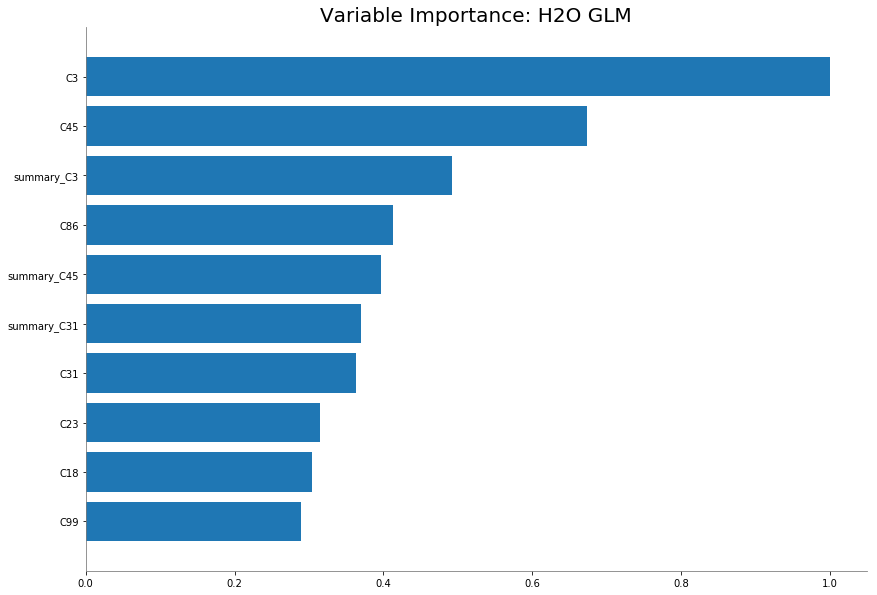

In [63]:
glm_logistic_plus_summary.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


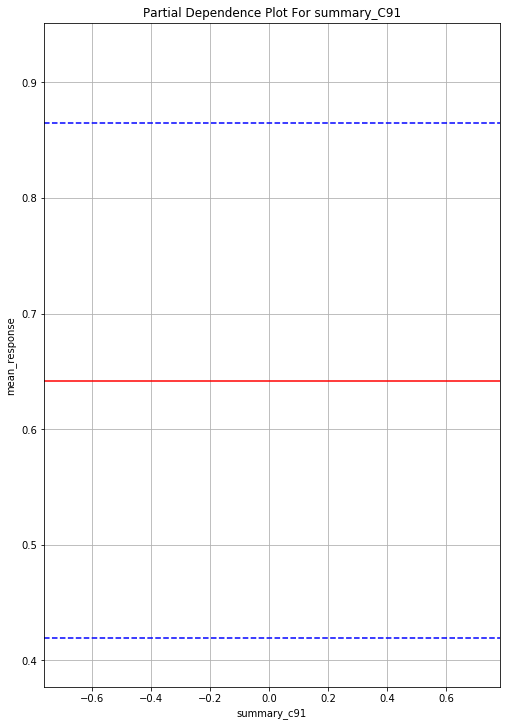

In [65]:
pdp_word_vecs = glm_logistic_plus_summary.partial_plot(data = ext_train_new, cols = ["summary_C91"])

### 2.3 Matrix

In [66]:
print("With Summary and Review Embeddings AUC: " + str(round(glm_logistic_plus_summary.auc(valid = True), 3)))

With Summary and Review Embeddings AUC: 0.848


In [67]:
glm_logistic_plus_summary.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4931477877207841: 


,0,1,Error,Rate
0,2494.0,1718.0,0.4079,(1718.0/4212.0)
1,623.0,6317.0,0.0898,(623.0/6940.0)
Total,3117.0,8035.0,0.2099,(2341.0/11152.0)


In [68]:
glm_logistic_plus_summary.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4931477877207841: 


,0,1,Error,Rate
0,2494.0,1718.0,0.4079,(1718.0/4212.0)
1,623.0,6317.0,0.0898,(623.0/6940.0)
Total,3117.0,8035.0,0.2099,(2341.0/11152.0)


## 3 Decision Tree

In [71]:
from h2o.estimators.random_forest import H2ORandomForestEstimator # for single tree
# in-notebook display
from IPython.display import Image
from IPython.display import display
%matplotlib inline

### 3.1 Train & Fit Model

In [72]:
predictors = ['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time'] + review_vecs.names + summary_vecs.names
response = 'PositiveReview'

In [74]:
# initialize single tree surrogate model
model_id = 'dt_surrogate_mojo'

# train single tree surrogate model
surrogate = H2OGradientBoostingEstimator(ntrees=1,
                                         sample_rate=1,
                                         col_sample_rate=1,
                                         max_depth=3,
                                         seed=12345,
                                         model_id=model_id)

_ = surrogate.train(x=predictors, y=response, training_frame=ext_train_new)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


### 3.2 Interpretability

### 3.3 Matrix

In [78]:
print(surrogate)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  dt_surrogate_mojo


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.2225735774835216
RMSE: 0.47177704213274474
LogLoss: 0.6365880515168578
Mean Per-Class Error: 0.3177387403912362
AUC: 0.7281796374726778
pr_auc: 0.5887501833299439
Gini: 0.45635927494535555
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.619282874611462: 


,0,1,Error,Rate
0,3315.0,12579.0,0.7914,(12579.0/15894.0)
1,944.0,27564.0,0.0331,(944.0/28508.0)
Total,4259.0,40143.0,0.3046,(13523.0/44402.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.6192829,0.8030182,6.0
max f2,0.5990054,0.8996806,7.0
max f0point5,0.6500440,0.7715799,3.0
max accuracy,0.6293106,0.7094500,5.0
max precision,0.6644458,0.8694007,0.0
max recall,0.5990054,1.0,7.0
max specificity,0.6644458,0.9326790,0.0
max absolute_mcc,0.6500440,0.3595765,3.0
max min_per_class_accuracy,0.6500440,0.6165220,3.0
max mean_per_class_accuracy,0.6500440,0.6822613,3.0


Gains/Lift Table: Avg response rate: 64.20 %, avg score: 64.18 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.1845187,0.6644458,1.3541157,1.3541157,0.8694007,0.6644458,0.8694007,0.6644458,0.2498597,0.2498597,35.4115695,35.4115695
,2,0.4180893,0.6529911,1.1717126,1.2522140,0.7522900,0.6529911,0.8039754,0.6580465,0.2736776,0.5235373,17.1712584,25.2214021
,3,0.6175172,0.6500440,1.1255358,1.2113031,0.7226426,0.6500623,0.7777089,0.6554680,0.2244633,0.7480006,12.5535836,21.1303145
,4,0.7172875,0.6304220,0.8202510,1.1569102,0.5266366,0.6304220,0.7427863,0.6519843,0.0818367,0.8298372,-17.9748950,15.6910204
,5,0.8192649,0.6293106,0.8031862,1.1128807,0.5156802,0.6293106,0.7145174,0.6491620,0.0819068,0.9117441,-19.6813780,11.2880674
,6,0.9040809,0.6192829,0.6501417,1.0694690,0.4174190,0.6192829,0.6866452,0.6463589,0.0551424,0.9668865,-34.9858321,6.9468994
,7,1.0,0.5990054,0.3452233,1.0,0.2216483,0.5990054,0.6420432,0.6418168,0.0331135,1.0,-65.4776671,0.0



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-04-17 00:21:03,0.012 sec,0.0,0.4793994,0.6522336,0.5,0.0,1.0,0.3579568
,2019-04-17 00:21:04,0.515 sec,1.0,0.4717770,0.6365881,0.7281796,0.5887502,1.3541157,0.3045584


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
C3,808.2933960,1.0,0.4808101
summary_C31,553.4595947,0.6847261,0.3292232
summary_C3,182.2331238,0.2254542,0.1084006
summary_C97,74.3465881,0.0919797,0.0442248
C86,62.7747459,0.0776633,0.0373413
---,---,---,---
summary_C95,0.0,0.0,0.0
summary_C96,0.0,0.0,0.0
summary_C98,0.0,0.0,0.0
summary_C99,0.0,0.0,0.0



See the whole table with table.as_data_frame()



## 4 Gradient Boosting

### 4.1 Train & Fit Model

In [85]:
gbm = H2OGradientBoostingEstimator(stopping_metric = "AUC",
                                           stopping_tolerance = 0.001,
                                           stopping_rounds = 5, 
                                           score_tree_interval = 10, 
                                           model_id = 'gbm.hex')
gbm.train(x = predictors, 
                   y = response,
                  training_frame = ext_train_new,
                  validation_frame = ext_test_new)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


### 4.2 Interpretability

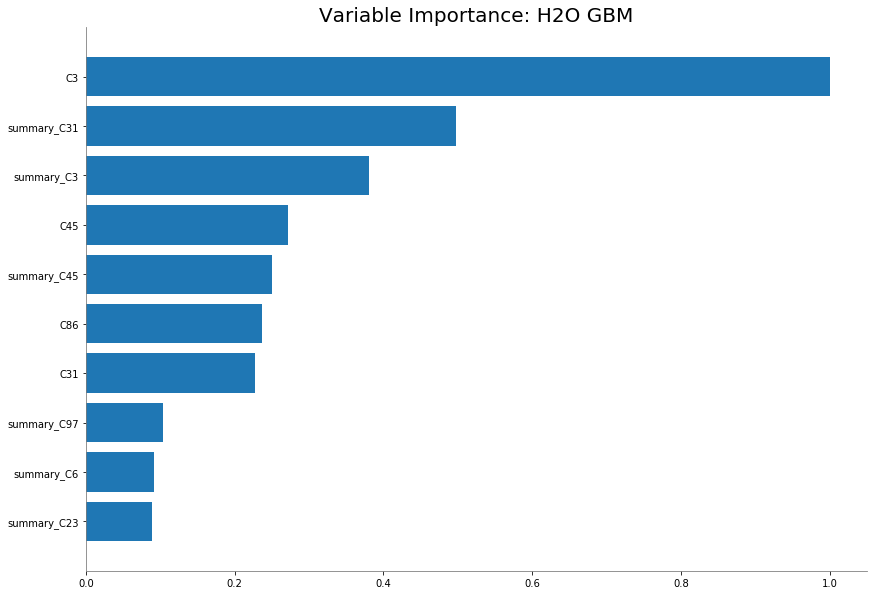

In [86]:
gbm.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


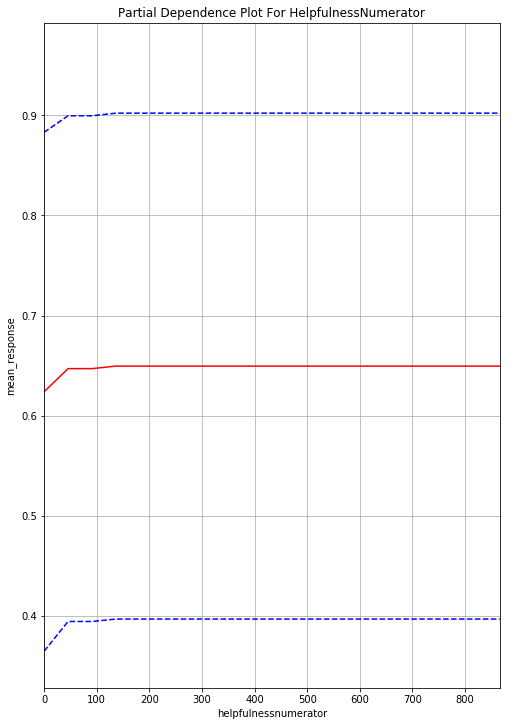

In [87]:
pdp_helpfulness = gbm.partial_plot(ext_train_new, cols = ['HelpfulnessNumerator'])

### 4.3 Matrix

In [88]:
print("AUC on validation data: " + str(round(gbm.auc(valid = True), 3)))

AUC on validation data: 0.846


In [89]:
gbm.confusion_matrix(valid=True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43968903074555216: 


,0,1,Error,Rate
0,2277.0,1935.0,0.4594,(1935.0/4212.0)
1,492.0,6448.0,0.0709,(492.0/6940.0)
Total,2769.0,8383.0,0.2176,(2427.0/11152.0)


In [90]:
gbm.r2(train=True, valid=True)

{'train': 0.4443099439519338, 'valid': 0.3584712380106454}

In [34]:
# h2o.cluster().shutdown()